# Environment Setup and Data Preparation

In this section, we perform all the necessary setup before diving into the core part of the project. This includes connecting to Google Drive, configuring access to Vertex AI, downloading the dataset, and preparing its elements for use in the following stages.

To use Vertex AI, we first create a project in Google Cloud and obtain the appropriate credentials. These credentials are then integrated into our code. Additionally, we connect the Google Colab environment to Google Cloud, enabling access to Gemini, Vertex AI models, and related APIs.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

path = 'NLP_Project'

os.chdir(f'/content/drive/MyDrive/{path}')
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1CFyMG46IyWxLkOBpkem_zUy2laPX-o4T/NLP_Project'

In [5]:
!pip install -q google-cloud-aiplatform

In [6]:
from google.colab import auth
auth.authenticate_user()

In [7]:
!pip install --upgrade --quiet google-genai langchain-google-vertexai langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.4/164.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.9 MB/s eta 0:00:00


In [42]:
from google import genai

genai_client = genai.Client(vertexai=True, project='gen-lang-client-0529947401', location='us-central1')

In [9]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [21]:
from datasets import load_dataset

# Load  the first 100 elements of the dataset
dataset = load_dataset("neural-bridge/rag-dataset-12000", split="train[:100]")

In [30]:
# creating a list of dictionaries for each element
dataset = [dict(example) for example in dataset]
type(dataset)

list

In [33]:
import json

print(json.dumps(dataset[:5], indent=2))

[
  {
    "context": "Caption: Tasmanian berry grower Nic Hansen showing Macau chef Antimo Merone around his property as part of export engagement activities.\nTHE RISE and rise of the Australian strawberry, raspberry and blackberry industries has seen the sectors redouble their international trade focus, with the release of a dedicated export plan to grow their global presence over the next 10 years.\nDriven by significant grower input, the Berry Export Summary 2028 maps the sectors\u2019 current position, where they want to be, high-opportunity markets and next steps.\nHort Innovation trade manager Jenny Van de Meeberg said the value and volume of raspberry and blackberry exports rose by 100 per cent between 2016 and 2017. She said the Australian strawberry industry experienced similar success with an almost 30 per cent rise in export volume and a 26 per cent rise in value to $32.6M over the same period.\n\u201cAustralian berry sectors are in a firm position at the moment,\u201d she 

# Defining Prompt Templates and needed functions

We define the necessary functions to support prompt templates and to query the model using zero-shot, one-shot, and few-shot prompt engineering techniques.

In [57]:
# Prompt Templates
def zero_shot_prompt(context, question):
    return f"""You are a helpful assistant. Use the context below to answer the question.

Context:
{context}

Question:
{question}

Answer:"""



def one_shot_prompt(ex_context, ex_question, ex_answer, context, question):
    return f"""You are a helpful assistant. Answer the question based on the context.

Example:
Context:
{ex_context}
Question:
{ex_question}
Answer:
{ex_answer}

Now try:
Context:
{context}
Question:
{question}
Answer:"""



def few_shot_prompt(examples, context, question):
    examples_text = "\n\n".join([
        f"Example {i+1}:\nContext:\n{ex['context']}\nQuestion:\n{ex['question']}\nAnswer:\n{ex['answer']}"
        for i, ex in enumerate(examples)
    ])

    return f"""You are a helpful assistant. Below are some examples of how to answer questions using context.

{examples_text}

Now, answer this question:
Context:
{context}
Question:
{question}
Answer:"""


In [39]:
# Querying the model
from google.genai.types import GenerateContentConfig


def get_gemini_answer(prompt):
    config = GenerateContentConfig(temperature=0.2, max_output_tokens=512)
    ''' temperature indicates how accurate or creative should the model be in answering,
    so we set it to 0.2 which tells the model to be accurate with its answers instead of being creative.
    max_output_tokens is also decided on based on the average and max number of tokens in the dataset for answers.
    '''
    response = genai_client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt,
        config=config
    )
    return response.text.strip()

# Quering the model with the prompts

In [49]:
# Zero Shots
zero_shot_results = []

for ex in dataset:
    # Create a zero-shot prompt using just context and question
    prompt = zero_shot_prompt(
        context=ex["context"],
        question=ex["question"]
    )

    # Send to Gemini
    prediction = get_gemini_answer(prompt)

    # Store result
    zero_shot_results.append({
        "question": ex["question"],
        "true_answer": ex["answer"],
        "prediction": prediction
    })

In [80]:
# View 5 results
import random, json

print(json.dumps(zero_shot_results[:5], indent=2))

[
  {
    "question": "What is the Berry Export Summary 2028 and what is its purpose?",
    "true_answer": "The Berry Export Summary 2028 is a dedicated export plan for the Australian strawberry, raspberry, and blackberry industries. It maps the sectors\u2019 current position, where they want to be, high-opportunity markets, and next steps. The purpose of this plan is to grow their global presence over the next 10 years.",
    "prediction": "The Berry Export Summary 2028 is a plan that maps out the current position of the Australian strawberry, raspberry, and blackberry sectors, where they want to be in the future, high-opportunity markets, and next steps. Its purpose is to grow the global presence of these industries over the next 10 years by focusing on international trade.",
    "bleu_score": 0.4838837719390435
  },
  {
    "question": "What are some of the benefits reported from having access to Self-supply water sources?",
    "true_answer": "Benefits reported from having access t

In [51]:
# Pick a single example as the one-shot reference
one_shot_example = random.choice(dataset)
print("One-shot example:\n",json.dumps(one_shot_example, indent=2))


One-shot example:
 {
  "context": "Like most things since M arrived, she has now hijacked my purse and made it her own. For the first year, I carried a diaper bag full of so many unnecessary baby items. Then, as she got older, and my shoulder started screaming at me every time I slung that huge bag on, I transitioned to carrying her stuff in my purse. Along with my typical wallet,\nM camera iPhone and crumpled pile of receipts, I\u2019ve accumulated an arsenal of toddler items to make our time outside of the house easier. What do you carry for your kids? I\u2019m so curious!\n- Snacks. Always Always filled with small \u2018nummies\u2019. The most important item for making it through any shopping trip with my girl.\n- Honest Diapers. We\u2019ve used these since she was born and I think I might actually be sad to see these cute patterns go once potty training commences.\n- Grocery Bag. Environmentally friendly. Do it!\n- Water. Gotta\u2019 wash those snacks down somehow.\n- Lip Balm. You

In [77]:
# One shot
one_shot_results = []

for ex in dataset:
    if ex == one_shot_example:
        continue

    # Create the one-shot prompt
    prompt = one_shot_prompt(
        ex_context=one_shot_example["context"],
        ex_question=one_shot_example["question"],
        ex_answer=one_shot_example["answer"],
        context=ex["context"],
        question=ex["question"]
    )

    # Send to Gemini
    prediction = get_gemini_answer(prompt)

    # Store results for later evaluation
    one_shot_results.append({
        "question": ex["question"],
        "true_answer": ex["answer"],
        "prediction": prediction
    })


In [81]:
# View 5 results
print(json.dumps(one_shot_results[:5], indent=2))

[
  {
    "question": "What is the Berry Export Summary 2028 and what is its purpose?",
    "true_answer": "The Berry Export Summary 2028 is a dedicated export plan for the Australian strawberry, raspberry, and blackberry industries. It maps the sectors\u2019 current position, where they want to be, high-opportunity markets, and next steps. The purpose of this plan is to grow their global presence over the next 10 years.",
    "prediction": "The Berry Export Summary 2028 is a dedicated export plan designed to grow the international presence of the Australian strawberry, raspberry, and blackberry industries over the next 10 years. It maps the sectors\u2019 current position, where they want to be, high-opportunity markets, and next steps."
  },
  {
    "question": "What are some of the benefits reported from having access to Self-supply water sources?",
    "true_answer": "Benefits reported from having access to Self-supply water sources include convenience, less time spent for fetching 

In [55]:
# Few-shot

# Pick k few-shot examples
few_shot_k = 3
few_shot_examples = random.sample(dataset, few_shot_k)

In [58]:
# Store results
few_shot_results = []

for ex in dataset:
    if ex in few_shot_examples:
        continue  # Skip examples already used in the prompt

    # Create prompt using few-shot examples
    prompt = few_shot_prompt(
        examples=few_shot_examples,
        context=ex["context"],
        question=ex["question"]
    )

    # Send to Gemini
    prediction = get_gemini_answer(prompt)

    # Store result
    few_shot_results.append({
        "question": ex["question"],
        "true_answer": ex["answer"],
        "prediction": prediction
    })

In [82]:
# View random 5 results
print(json.dumps(few_shot_results[:5], indent=2))

[
  {
    "question": "What is the Berry Export Summary 2028 and what is its purpose?",
    "true_answer": "The Berry Export Summary 2028 is a dedicated export plan for the Australian strawberry, raspberry, and blackberry industries. It maps the sectors\u2019 current position, where they want to be, high-opportunity markets, and next steps. The purpose of this plan is to grow their global presence over the next 10 years.",
    "prediction": "The Berry Export Summary 2028 is an export plan designed to grow the global presence of the Australian strawberry, raspberry, and blackberry industries over the next 10 years. It maps the sectors\u2019 current position, where they want to be, high-opportunity markets, and next steps."
  },
  {
    "question": "What are some of the benefits reported from having access to Self-supply water sources?",
    "true_answer": "Benefits reported from having access to Self-supply water sources include convenience, less time spent for fetching water and access

# Evaluation and comparison of Performances

In this section, we first evaluate the predictions using the BLEU score. Then, we obtain embeddings for both the ground truth and predicted answers, and compute the cosine similarity between them to assess their semantic similarity.


**BLEU score** compares answers by checking how many exact words or short phrases match. It works well when the predicted answer uses similar wording. But if the model says the same thing in different words (like “She won the match” vs “She was victorious”), BLEU gives a low score.


In contrast, **cosine similarity** between sentence embeddings captures semantic similarity, allowing it to recognize answers that are worded differently but convey the same meaning.

## BLEU Score Evaluation (from NLTK)

In [66]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [67]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

def bleu_score(predicted, actual):
    reference = [word_tokenize(actual.lower())]
    candidate = word_tokenize(predicted.lower())
    smoothie = SmoothingFunction().method4
    return sentence_bleu(reference, candidate, smoothing_function=smoothie)

### BLEU Score Evaluation on ZERO SHOT RESULTS

In [89]:
# Compute BLEU scores for zero-shot results
zero_shot_scored_results = []
for r in zero_shot_results:
    score = bleu_score(r["prediction"], r["true_answer"])
    r["bleu_score"] = score
    zero_shot_scored_results.append(r)

In [86]:
# Calculate average BLEU score
zero_shot_average_bleu = sum(r["bleu_score"] for r in zero_shot_scored_results) / len(zero_shot_scored_results)
print(f"Zero Shot Average BLEU Score: {zero_shot_average_bleu:.3f}")

Zero Shot Average BLEU Score: 0.463


In [87]:
# Show 5 low-scoring examples

sorted_results = sorted(zero_shot_scored_results, key=lambda x: x["bleu_score"])

# Step 3: Show 5 lowest scoring examples
for r in sorted_results[:5]:
    print("🔍 Low BLEU Score Example:")
    print("Q:", r["question"])
    print("Prediction:", r["prediction"])
    print("Expected:", r["true_answer"])
    print("BLEU Score:", round(r["bleu_score"], 2))
    print("-" * 60)

🔍 Low BLEU Score Example:
Q: Who was let go after not responding to an email offering to extend his employment?
Prediction: Nicholas Allegra was let go after not responding to an email offering to extend his employment.
Expected: Nicholas Allegra.
BLEU Score: 0.04
------------------------------------------------------------
🔍 Low BLEU Score Example:
Q: What is the purpose of recycling concrete in construction?
Prediction: Recycling concrete in construction serves several purposes:

*   **Creating aggregate for new concrete:** Crushed concrete can be used as aggregate in new concrete mixes, reducing the need for virgin materials.
*   **Reducing construction costs:** Reusing concrete can lower expenses associated with material sourcing and disposal.
*   **Conserving landfill space:** Recycling concrete diverts it from landfills, preserving valuable space.
*   **Resource conservation:** Substituting crushed concrete for virgin materials promotes sustainable use of resources.
*   **On-site

### BLEU Score Evaluation on ONE SHOT RESULTS

In [83]:
# Compute BLEU scores for one-shot results
one_shot_scored_results = []
for r in one_shot_results:
    score = bleu_score(r["prediction"], r["true_answer"])
    r["bleu_score"] = score
    one_shot_scored_results.append(r)

In [84]:
# Calculate average BLEU score
one_shot_average_bleu = sum(r["bleu_score"] for r in one_shot_scored_results) / len(one_shot_scored_results)
print(f"One-shot Average BLEU Score: {one_shot_average_bleu:.3f}")

One-shot Average BLEU Score: 0.543


In [88]:
# Show 5 lowest scoring examples
sorted_results = sorted(one_shot_scored_results, key=lambda x: x["bleu_score"])

for r in sorted_results[:5]:
    print("🔍 Low BLEU Score Example (One-shot):")
    print("Q:", r["question"])
    print("Prediction:", r["prediction"])
    print("Expected:", r["true_answer"])
    print("BLEU Score:", round(r["bleu_score"], 2))
    print("-" * 60)

🔍 Low BLEU Score Example (One-shot):
Q: What are some of the main ingredients used in the composition of lip gloss?
Prediction: Some of the main ingredients used in the composition of lip gloss are emollients, thickeners, and coloring agents.
Expected: Some main materials used in every type of lip gloss include emollients like jojoba oil, coconut oil, and vitamin E, or synthetic oils. Another essential component in lip gloss is thickeners like clays and waxes, which can be either natural or synthetic. Lip gloss also contains coloring agents, which can be either natural materials like fruit extracts or chemical dyes. Glittery lip gloss products even depend on ingredients like mica and iron oxide. Other ingredients can include sunscreen for UV products, sweeteners for flavored lip gloss, and paraben-based preservatives to help them stay fresh for longer.
BLEU Score: 0.0
------------------------------------------------------------
🔍 Low BLEU Score Example (One-shot):
Q: Who was let go aft

### BLEU Score Evaluation on FEW SHOT RESULTS

In [90]:
# Compute BLEU scores for few-shot results
few_shot_scored_results = []
for r in few_shot_results:
    score = bleu_score(r["prediction"], r["true_answer"])
    r["bleu_score"] = score
    few_shot_scored_results.append(r)

In [91]:
# Calculate average BLEU score
few_shot_average_bleu = sum(r["bleu_score"] for r in few_shot_scored_results) / len(few_shot_scored_results)
print(f"Few-shot Average BLEU Score: {few_shot_average_bleu:.3f}")

Few-shot Average BLEU Score: 0.568


In [92]:
# Show 5 lowest scoring examples
sorted_results = sorted(few_shot_scored_results, key=lambda x: x["bleu_score"])

for r in sorted_results[:5]:
    print("🔍 Low BLEU Score Example (Few-shot):")
    print("Q:", r["question"])
    print("Prediction:", r["prediction"])
    print("Expected:", r["true_answer"])
    print("BLEU Score:", round(r["bleu_score"], 2))
    print("-" * 60)

🔍 Low BLEU Score Example (Few-shot):
Q: Who was let go after not responding to an email offering to extend his employment?
Prediction: Nicholas Allegra, who was hired last year after gaining fame at JailBreakMe, was let go after not responding to an e-mail offering to extend his employment.
Expected: Nicholas Allegra.
BLEU Score: 0.02
------------------------------------------------------------
🔍 Low BLEU Score Example (Few-shot):
Q: Can PXI-8512 modules be used to send and receive data with CAN protocol between two PXI 8880 controllers?
Prediction: Yes, according to the response, PXI-8512 modules can be used to send and receive data with CAN protocol between two PXI 8880 controllers.
Expected: Yes, you can use CAN to share data between your controllers.
BLEU Score: 0.04
------------------------------------------------------------
🔍 Low BLEU Score Example (Few-shot):
Q: Who are the characters in Wuthering Heights that display a "diseased mind" and a "diseased body"?
Prediction: Based o

## Cosine Similarity on word embeddings

In this approach, we first need to get the word embeddings of true answer and the predicted answer and then compute their cosine similarity.

In [93]:
import vertexai
from vertexai.preview.language_models import TextEmbeddingModel

vertexai.init(project="gen-lang-client-0529947401", location="us-central1")

In [101]:
import numpy as np

def embed_texts(texts):
    model = TextEmbeddingModel.from_pretrained("text-embedding-005") # latest stable embedding model of vertex ai.

    # Batch processing for embeddings
    all_embeddings = model.get_embeddings(texts)

    return all_embeddings  # List of embedding vectors

In [114]:
# Set the lists of texts that need to be embedded
zero_shot_prediction = [r["prediction"] for r in zero_shot_scored_results]

one_shot_prediction = [r["prediction"] for r in one_shot_scored_results]

few_shot_prediction = [r["prediction"] for r in few_shot_scored_results]

true_answer = [r["answer"] for r in dataset] # shared for all the zero, one and few shots

In [117]:
print(zero_shot_prediction[0])
print(one_shot_prediction[0])
print(few_shot_prediction[0])
print(true_answer[0])

The Berry Export Summary 2028 is a plan that maps out the current position of the Australian strawberry, raspberry, and blackberry sectors, where they want to be in the future, high-opportunity markets, and next steps. Its purpose is to grow the global presence of these industries over the next 10 years by focusing on international trade.
The Berry Export Summary 2028 is a dedicated export plan designed to grow the international presence of the Australian strawberry, raspberry, and blackberry industries over the next 10 years. It maps the sectors’ current position, where they want to be, high-opportunity markets, and next steps.
The Berry Export Summary 2028 is an export plan designed to grow the global presence of the Australian strawberry, raspberry, and blackberry industries over the next 10 years. It maps the sectors’ current position, where they want to be, high-opportunity markets, and next steps.
The Berry Export Summary 2028 is a dedicated export plan for the Australian strawbe

In [118]:
# Get embeddings
zero_shot_prediction_embeddings = embed_texts(zero_shot_prediction)

one_shot_prediction_embeddings = embed_texts(one_shot_prediction)

few_shot_prediction_embeddings = embed_texts(few_shot_prediction)

true_answer_embeddings = embed_texts(true_answer) # again shared for all the zero, one and few shots

In [119]:
# Calculating the cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def compute_cosine_similarities(predictions_embeddings, true_answer_embeddings):
    cosine_similarities = []

    # Loop through each pair of corresponding prediction and true answer embeddings
    for pred_emb, true_emb in zip(predictions_embeddings, true_answer_embeddings):
        # Ensure the embeddings are numpy arrays (if not already)
        pred_emb = np.array(pred_emb.values)
        true_emb = np.array(true_emb.values)

        # Calculate cosine similarity between the two vectors
        similarity = cosine_similarity([pred_emb], [true_emb])[0][0]
        cosine_similarities.append(similarity)

    # Calculate the average cosine similarity
    avg_cosine_similarity = np.mean(cosine_similarities)

    return cosine_similarities, avg_cosine_similarity

In [120]:
# Compute cosine similarities for Zero-shot
zero_shot_cosine_similarities, zero_shot_avg_cosine = compute_cosine_similarities(
    zero_shot_prediction_embeddings, zero_shot_true_answer_embeddings
)
print(f"Average Cosine Similarity (Zero-shot): {zero_shot_avg_cosine:.3f}")

Average Cosine Similarity (Zero-shot): 0.937


In [121]:
# Compute cosine similarities for One-shot
one_shot_cosine_similarities, one_shot_avg_cosine = compute_cosine_similarities(
    one_shot_prediction_embeddings, zero_shot_true_answer_embeddings
)
print(f"Average Cosine Similarity (One-shot): {one_shot_avg_cosine:.3f}")

Average Cosine Similarity (One-shot): 0.856


In [122]:
# Compute cosine similarities for Few-shot
few_shot_cosine_similarities, few_shot_avg_cosine = compute_cosine_similarities(
    few_shot_prediction_embeddings, zero_shot_true_answer_embeddings
)
print(f"Average Cosine Similarity (Few-shot): {few_shot_avg_cosine:.3f}")

Average Cosine Similarity (Few-shot): 0.784


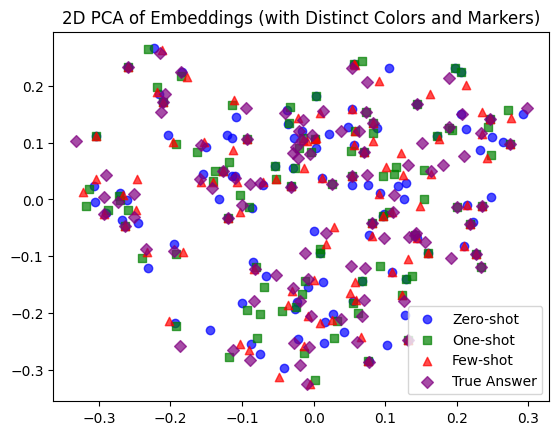

In [137]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Extract the vectors (e.g., embeddings) from the TextEmbedding objects
zero_shot_pred_embeddings = np.array([e.values for e in zero_shot_prediction_embeddings])
one_shot_pred_embeddings = np.array([e.values for e in one_shot_prediction_embeddings])
few_shot_pred_embeddings = np.array([e.values for e in few_shot_prediction_embeddings])

# If true_answer_embeddings is already a numpy array, you don't need .values
true_answer_embeddings = true_answer_embeddings  # No need for .values

# Combine all embeddings (predictions and true answers)
embeddings_subset = np.vstack([
    zero_shot_pred_embeddings[:100],
    one_shot_pred_embeddings[:100],
    few_shot_pred_embeddings[:100],
    true_answer_embeddings[:100]  # Ensure slicing if it's a large array
])

# Apply PCA to reduce the dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_subset)

# Plot the embeddings with distinct colors and markers
plt.scatter(reduced_embeddings[:len(zero_shot_pred_embeddings), 0], reduced_embeddings[:len(zero_shot_pred_embeddings), 1], label='Zero-shot', color='blue', marker='o', alpha=0.7)
plt.scatter(reduced_embeddings[len(zero_shot_pred_embeddings):len(zero_shot_pred_embeddings)+len(one_shot_pred_embeddings), 0],
            reduced_embeddings[len(zero_shot_pred_embeddings):len(zero_shot_pred_embeddings)+len(one_shot_pred_embeddings), 1],
            label='One-shot', color='green', marker='s', alpha=0.7)
plt.scatter(reduced_embeddings[len(zero_shot_pred_embeddings)+len(one_shot_pred_embeddings):len(zero_shot_pred_embeddings)+len(one_shot_pred_embeddings)+len(few_shot_pred_embeddings), 0],
            reduced_embeddings[len(zero_shot_pred_embeddings)+len(one_shot_pred_embeddings):len(zero_shot_pred_embeddings)+len(one_shot_pred_embeddings)+len(few_shot_pred_embeddings), 1],
            label='Few-shot', color='red', marker='^', alpha=0.7)
plt.scatter(reduced_embeddings[len(zero_shot_pred_embeddings)+len(one_shot_pred_embeddings)+len(few_shot_pred_embeddings):, 0],
            reduced_embeddings[len(zero_shot_pred_embeddings)+len(one_shot_pred_embeddings)+len(few_shot_pred_embeddings):, 1],
            label='True Answer', color='purple', marker='D', alpha=0.7)

# Add legend and title
plt.legend()
plt.title("2D PCA of Embeddings (with Distinct Colors and Markers)")
plt.show()


# Summary of results

In [125]:
!pip install pandas

In [135]:
import pandas as pd

# Sample data (replace with your actual results)
summary_data = {
    'Approach': ['Zero-shot', 'One-shot', 'Few-shot'],
    'Average BLEU Score': [zero_shot_average_bleu, one_shot_average_bleu, few_shot_average_bleu],  # Replace with your BLEU scores
    'Average Cosine Similarity': [zero_shot_avg_cosine, one_shot_avg_cosine, few_shot_avg_cosine]  # Replace with your cosine similarity
}

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Apply styles
styled_df = summary_df.style.set_table_styles(
    [
        {'selector': 'th', 'props': [('background-color', 'lightgray'), ('font-weight', 'bold'), ('border', '1px solid black'), ('padding', '10px')]},  # Header styles
        {'selector': 'td', 'props': [('border', '1px solid black'), ('padding', '10px'), ('text-align', 'center')]},  # Cell styles
    ]
).hide(axis="index")  # Hide the index

# Display the cleaned DataFrame with visible lines and centered numbers
styled_df

Approach,Average BLEU Score,Average Cosine Similarity
Zero-shot,0.462528,0.936560
One-shot,0.543148,0.855686
Few-shot,0.568479,0.784146
